# Tutorials
https://github.com/NielsRogge/Transformers-Tutorials/blob/master/VisionTransformer/Quick_demo_of_HuggingFace_version_of_Vision_Transformer_inference.ipynb
https://huggingface.co/docs/transformers/en/model_doc/trocr

Vision Text Dual-Encoder: CLIP and Contrastive Learning
https://github.com/huggingface/transformers/blob/main/examples/pytorch/contrastive-image-text/README.md
https://huggingface.co/blog/vision_language_pretraining
https://medium.com/@brianpulfer/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c

In [1]:
import numpy as numpy
import pandas as pd
import matplotlib as plt
from transformers import ViTForImageClassification

# Import and the model and processor


In [2]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import torch

# VISION TEXT ENCODER DECODER


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f" Using device: {device} : {torch.cuda.get_device_name(device)}")


processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')

model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')

model.save_pretrained("TrOCR")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


 Using device: cuda : NVIDIA GeForce RTX 4070 Ti SUPER


Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.48.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

In [3]:
# Image collation and preprocessing function

import torch
import random

def collate_function(batch):
    images = [item['image'] for item in batch]
    formulas = [item['formula'] for item in batch]

    # Get the maximum height and width in the batch
    max_height = max(image.size(1) for image in images)
    max_width = max(image.size(2) for image in images)

    # Pad the images to the maximum height and width in the batch
    processed_images = []
    for image in images:
        height, width = image.size(1), image.size(2)

        ## Scale images to match the same width and height of the largest image in the batch
        # Calculate the new height and width of the padded image
        if (max_height - height)/height  < (max_width - width)/width:
            scaling_factor = max_height / height
        else:
            scaling_factor = max_width / width
        
        # scale the new height and widht
        new_height = int(height * scaling_factor)
        new_width = int(width * scaling_factor)

        resized_image = torch.nn.functional.interpolate(
            image.unsqueeze(0), 
            size = (new_height, new_width), 
            mode='bilinear'
        ).squeeze(0)
        
        ## min-max scaling to normalize all images
        min_val = torch.min(resized_image)
        max_val = torch.max(resized_image)
        # Prevent division by zero
        if max_val > min_val:
            resized_image = (resized_image - min_val) / (max_val - min_val)
        else:
            # If max == min, just set to zeros or a constant value
            resized_image = torch.zeros_like(resized_image)
        
    
        # pad and append 5 images with random displacement within batch maximum image size bounds
        for _ in range(5):
            ## Pad images to match the same width and height
            padded_image = torch.ones(image.size(0), max_height, max_width)
            # calculate offsets
            off_x = int(random.random() * (max_width - new_width)) if max_width > new_width else 0
            off_y = int(random.random() * (max_height - new_height)) if max_height > new_height else 0

            padded_image[:, off_y:(new_height + off_y), off_x:(new_width + off_x)] = resized_image

            # add images into processed images array
            processed_images.append(padded_image)
    
    # Stack the resized images
    resized_images = torch.stack(processed_images)

    return {'image': resized_images, 'formula': formulas}

In [4]:
# Assemble dataset
import os
from skimage import io, transform
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision import transforms


# ==== ++++ ==== ++++ ==== ++++ ==== ++++ ==== ++++ ==== ++++ ==== ++++ ==== ++++ 
  # PATHS AND PRESETS
   
images_folder = "dataset/IM2LATEX-100K-HANDWRITTEN/images"
train_list = "dataset/IM2LATEX-100K-HANDWRITTEN/train.lst"
test_list = "dataset/IM2LATEX-100K-HANDWRITTEN/test.lst"
val_list = "dataset/IM2LATEX-100K-HANDWRITTEN/val.lst"
formulas_file = "dataset/IM2LATEX-100K-HANDWRITTEN/formulas.lst"
batch_size = 2

output_dir = "output/"

# ==== ++++ ==== ++++ ==== ++++ ==== ++++ ==== ++++ ==== ++++ ==== ++++ ==== ++++ 

class IM2LATEXDataset(Dataset):
    def __init__(self, images_folder, list_file, formulas_file, transform=None):
        self.images_folder = images_folder
        self.transform = transform
        self.list_file = list_file
        self.formula_file = formulas_file

        try:
            with open(list_file, 'r') as f:
                self.formula_image_pairs = [line.strip().split() for line in f]
            with open(formulas_file, 'r') as f:
                self.formulas = f.read().splitlines()
        except FileNotFoundError:
            print("This file does not exist.")
            raise
        #print(self.formulas[11869], self.formula_image_pairs[70975])

    def __len__(self):
        return len(self.formula_image_pairs)

    def __getitem__(self, idx):
        try:
            # get formula_image pairs
            pair = self.formula_image_pairs[idx]

            if len(pair) >= 2:
                formula_idx = pair[0]
                img_name = pair[1]
            else:
                raise ValueError(f"Expected at least 2 values in pair but got: {pair}")

            # create image path from image name
            img_path = os.path.join(self.images_folder, img_name + ".png")

            #attempt to open images and convert to greyscale
            try:
                image = Image.open(img_path)#.convert('L')
            except FileNotFoundError:
                print(f"Image not found: {img_path}")
                raise

            # transform image if transform exists
            if self.transform:
                image = self.transform(image)
            
            # find coresponding formulas
            formula = self.formulas[int(formula_idx)]

            return {"image": image, "formula": formula}
        
        except Exception as e:
            # catch imageloading exceptions
            print(f"Error in __getitem__ at index {idx}: {e}")
            print(f"Image-formula pair: {self.formula_image_pairs[idx]}")
            raise

def load_im2latex_dataset(images_folder, train_list, test_list, val_list, formulas_file, batch_size=batch_size, transform=None):
    
    # create transforms for image
    if transform is None:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485], std=[0.229]),
            #transforms.Resize((224, 224))
        ])
    
    # create train, test, validation datasets
    train_dataset = IM2LATEXDataset(images_folder, train_list, formulas_file, transform)
    test_dataset = IM2LATEXDataset(images_folder, test_list, formulas_file, transform)
    val_dataset = IM2LATEXDataset(images_folder, val_list, formulas_file, transform)
    
    # load datasets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_function)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_function)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_function)
    
    return train_loader, test_loader, val_loader


# run dataset loader
train_loader, test_loader, val_loader = load_im2latex_dataset(images_folder, train_list, test_list, val_list, formulas_file, batch_size=batch_size)

Formula example: F_\lambda =\sum _{\lambda _0 ,...,\lambda _{k-1}}d\rho _{\lambda _0}\wedge d\rho _{\lambda _1}\wedge ...\wedge d\rho _{\lambda _{k-1}}\wedge d\log g_{\lambda \lambda _0\lambda _1 ...\lambda _{k-1}}


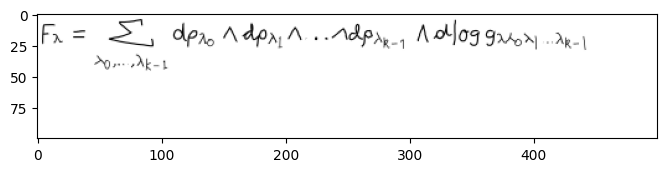

Formula example: {\cal L}_M=(h_d)_{fg}(\bar{d}_f)_L(d_g)_Rv_1-(h_u)_{fg}(\bar{u}_f)_L(u_g)_Rv_2


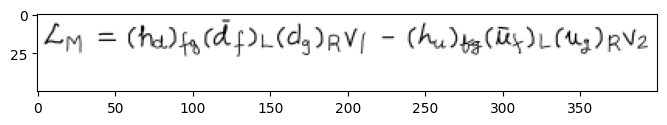

Formula example: R_{mnkl}=e^B\Omega_{mnkl} +\frac{1}{4}\left(B'e^B\right)^2\left(g_{nk}g_{ml}-g_{nl}g_{mk}\right)~,


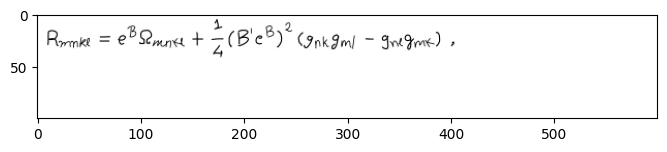

Formula example: \alpha_l = \left\{\begin{array}{ll}1, & l=0, \\q^{j(jp(p-1)+rp-p+1)}& l=jp ~(j \geq 1), \\q^{j(jp(p-1)-rp+p-1)}& l=jp-r+1 ~(j \geq 1), \\-q^{(j(p-1)+r)(jp+1)}& l=jp +1 ~(j \geq 0), \\-q^{(j(p-1)-r)(jp-1)}& l=jp-r ~(j\geq 1), \\0, & \mbox{otherwise},\end{array} \right.\label{eqn:L3}


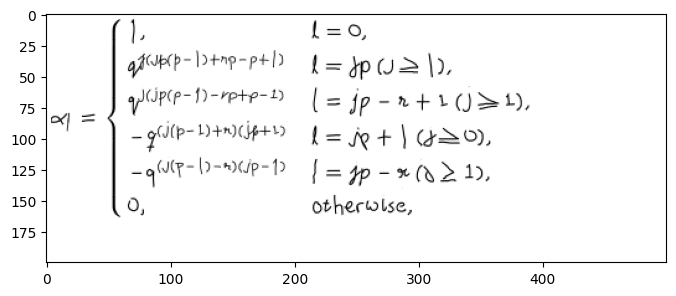

Formula example: B(\vec{x},t)\rightarrow (U^{(\beta)})^{-1} B(\vec{x},t) U^{(\beta)} =B(\vec{x},0)


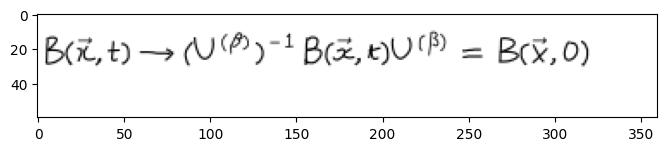

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Print dataset samples to verify
count =0
for batch in train_loader:
    
    print(f"Formula example: {batch['formula'][0]}")

    img_tensor = batch['image'][0]
    img_numpy = img_tensor.permute(1, 2, 0).numpy()

    plt.figure(figsize=(8,8))
    plt.imshow(img_numpy, cmap='grey')
    plt.show()
    if count ==4:
        break
    count+=1


In [6]:
# Detect Checkpoint
from transformers.trainer_utils import get_last_checkpoint

last_checkpoint = None
if os.path.isdir(output_dir):
    last_checkpoint = get_last_checkpoint(output_dir)
    if last_checkpoint is None and len(os.listdir(output_dir)) > 0:
        raise ValueError(
            f"Output directory ({output_dir}) already exists and is not empty. "
            "Use --overwrite_output_dir to overcome."
        )
    elif last_checkpoint is not None:
        print(
            f"Checkpoint detected, resuming training at {last_checkpoint}. To avoid this behavior, change "
            "the `--output_dir` or add `--overwrite_output_dir` to train from scratch."
        )

In [7]:
model.to(device)

# Preprocess the image
batch = next(iter(train_loader))
pixel_values = processor(batch['image'], return_tensors="pt").pixel_values.to(device)

# Run inference
with torch.no_grad():
    generated_ids = model.generate(pixel_values)

# Decode the generated IDs to text
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)

# Print the output
print("Generated Text:", generated_text[0])

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Generated Text: 0 0


In [ ]:
# Training 
import torch.optim as optim
from torch.amp import autocast, GradScaler
import os
torch.cuda.empty_cache()


# DSA blocking
#export CUDA_LAUNCH_BLOCKING=1
os.environ["CUDA_LAUNCH_BLOCKING"] = '1'

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
model.to(device)

# Gradscaler
scaler = GradScaler()

# Set up optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Hyper Parameters
accumulation_steps = 4
num_epochs = 3

# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        
        # Move data to device
          # Texts should be in a format suitable for the tokenizer

        # Training
        model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
        model.config.pad_token_id = processor.tokenizer.pad_token_id
        model.config.vocab_size = model.config.decoder.vocab_size

        # Encode texts
        #text_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt').to(device)
        #processor(images, texts)
        pixel_values = processor(batch['image'], return_tensors="pt").pixel_values.to(device) #images = batch['image'].to(device)
        #torch.tensor()
        labels = processor.tokenizer(text = batch['formula'], max_length=512, truncation=True, return_tensors="pt",padding=True).input_ids.to(device)

        # Forward pass (with mixed precision)
        with autocast(device_type='cuda'):
          outputs = model(pixel_values=pixel_values, labels=labels)
          #print("Model output shape:", outputs.size)  # Check output shape
          #print("Labels:", labels)  # Check label values
          # Compute loss (you may need to define a suitable loss function)
          loss = outputs.loss  # Assuming the model returns a loss attribute

        # Backward pass and optimization
        optimizer.zero_grad()
        scaler.scale(loss).backward() # loss.backward()
        scaler.step(optimizer) # optimizer.step()
        scaler.update()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the model and processor
model.save_pretrained("clip-roberta")
processor.save_pretrained("clip-roberta")

Epoch [1/3], Loss: 2.0231
